# Short Iron Condor

### I. Strategy Overview

* This strategy is composed of 2 credit spread:
    * 1 put credit spread with short leg around 10-15 delta with <15% ITM at expiration
    * 1 call credit spread with short leg around 10-15 delta with <15% ITM at expiration
* This is a high probability strategy with defined risk thus moderate buying power requirement

#### Payoff
Option Payoff or Profit and Loss (P&L) diagrams help us understand where our options strategies win or lose money at expiration based on different stock price points.

![](iron_condor.jpg)

#### Features （Optional):
* Defined risk strategy
* Delta Neutral: strategy profits if stock price expires between the strikes
* Long Theta: profit of the strategy increases as time decays
* Short volatility: profit of the strategy increases as the implied volatility drops

### II. Strategy Setup
* Observe the historical price of selected underlying
* Find avaialble expiration dates for options
* Select an expiration date, option type and stike price for the option strategy
* Select entrance and exit point (simplified by choosing future enter and exit dates)

In [1]:
import sys  
sys.path.insert(0, 'C:\\Users\\chena\\Desktop\\Trading\\StrategicOptions\\')
import datetime
from Functions.mainprg import GetDays, GetPayOff, GetBackTesting, GetPriceHistory
import pandas as pd
import numpy as np
from datetime import timedelta

Grabbing new access token...


####  a. Select underlying by ticker

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


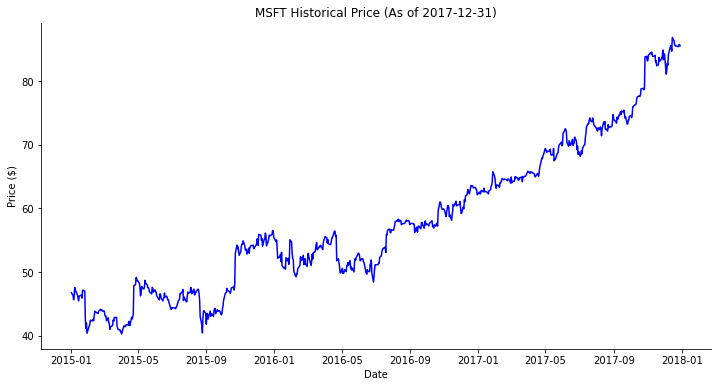

In [2]:
Ticker = 'MSFT'
GetPriceHistory(Ticker).plot_price_history()

#### b. Find expiration dates for testing period

In [3]:
Start_Date = datetime.datetime(2018, 1, 4)
End_Date = datetime.datetime(2018,6, 30)

GetDays(Ticker, Start_Date, End_Date, []).expiration_dates

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


,Expiration Date,Day of the Week,Year-Month,Expiration
0,2018-01-19,Friday,2018-01,1
1,2018-02-16,Friday,2018-02,1
2,2018-03-16,Friday,2018-03,1
3,2018-04-20,Friday,2018-04,1
4,2018-05-18,Friday,2018-05,1
5,2018-06-15,Friday,2018-06,1


#### c. Select an expiration date, choose option type (call) and strike price

In [4]:
expiration = datetime.datetime(2018, 3, 18)
option_type = ['P', 'P', 'C', 'C']  # C(all), P(ut)
action = ['L', 'S', 'S', 'L']  #L(ong), S(hort)

# Change the strike price to see how it affects the strategy
strike_price = [75, 80, 90, 95]  # Deep in the money


#### d. Choose option enter and exit dates

In [5]:
entry_date = datetime.datetime(2018, 1, 2)
exit_date = datetime.datetime(2018, 3, 5)

### III. Visualization
#### a. Generate option(s) price and payoff

Option Premium = $0.25


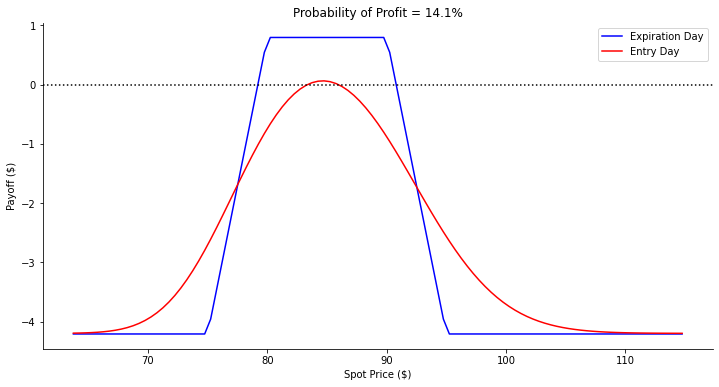

In [6]:
payoff = GetPayOff(Ticker, strike_price, entry_date, expiration, option_type, action)
print('Option Premium = '+"${:.2f}".format(payoff.option_price[0] + payoff.option_price[1]))
payoff.plot_payoff()

#### * Probability of profit here is incorrect (needs more work)

##### b. Compare returns by holding the option vs. buy&hold the underlying

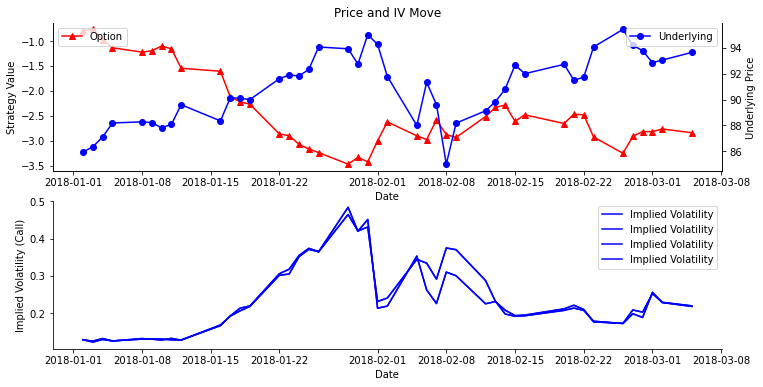

In [7]:
bt1 = GetBackTesting(Ticker, strike_price, expiration, entry_date, exit_date, option_type, action)
bt1.plot_price_history()

#### * 2 IV curves for put and call respectively.  Will retouch the plot later

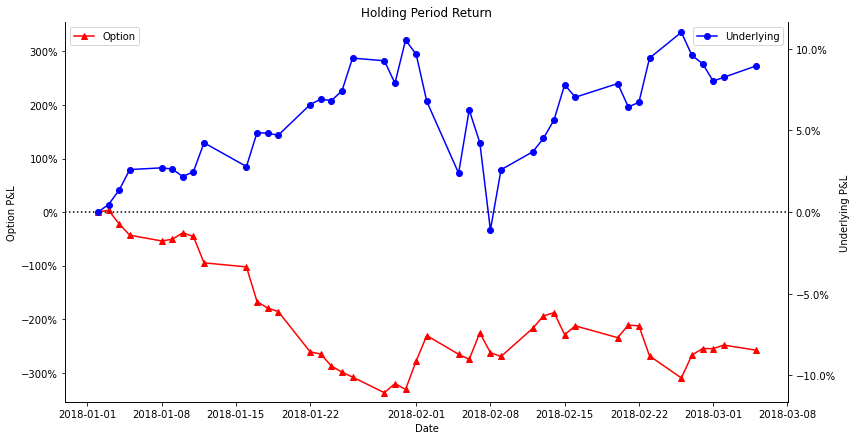

In [9]:
bt1.plot_option_pnl()

#### c. Strategy Summary

In [10]:
bt1.strategy_summary

,Entry Date,Cost Basis,Exit Date,Holding Period (Days),Residual Value,P&L,PnL/Day,ROC,Win
0,2018-01-02,$-79.44,2018-03-05,62,$-284.04,$-204.60,$-3.30,-257.5%,False


### III. Recurring Strategy Setup

#### a. Choose the backtesting period for the recurring startegy

In [11]:
Start_Date = datetime.datetime(2016, 1, 4)
End_Date = datetime.datetime(2018,8, 30)

expiry = GetDays(Ticker, Start_Date, End_Date, []).expiration_dates
trading_days = GetDays(Ticker, Start_Date, End_Date, []).trading_days
trading_days['Year-Month'] = pd.to_datetime(trading_days['Date']).dt.to_period('M') + 1  # +1 to find the expiration date in the next month

dte_seeker = pd.merge(trading_days, expiry, on='Year-Month', how='left')
dte_seeker['DTE'] = (pd.to_datetime(dte_seeker['Expiration Date']) - pd.to_datetime(dte_seeker['Date'])).dt.days
dte_seeker.dropna(inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


#### b. Set trading rules

#### Simplified (current):
* Enter: 43 days before expriation
* Exit: 21 days before expiration
* Strike prices:
* Put spread: enter day underlying price - \\$7.5 & underlying price - \\$10
* Short Call: enter day underlying price + \\$7.5 & underlying price + \\$10

In [12]:
entry_dates = pd.to_datetime(dte_seeker[dte_seeker['DTE']==43]['Date'].reset_index(drop=True))
expiration_dates = pd.to_datetime(dte_seeker[dte_seeker['DTE']==43]['Expiration Date'].reset_index(drop=True))
exit_dates = entry_dates + timedelta(days=24)
expiration_dates = pd.to_datetime(expiration_dates)

#### c. Run recursive analysis

In [13]:
strategy_performance = pd.DataFrame([])
strat_sum_for_stats = []
strike_price = [31, 33, 45, 48]
i = 0
for _ in entry_dates:
    bt = GetBackTesting(Ticker, strike_price, expiration_dates[i], entry_dates[i], exit_dates[i], option_type, action)
    strategy_performance = strategy_performance.append(bt.strategy_summary)
    strat_sum_for_stats.append(bt.strat_sum_for_stats)
    i += 1
    end_of_period_spot = bt.underlying_price_truncated_['close'][-1]
    strike_price = [end_of_period_spot-10, end_of_period_spot-7.5, end_of_period_spot+7.5, end_of_period_spot+10]
    
win_rate = "{:.2%}".format(strategy_performance['Win'].sum()/len(strategy_performance['Win']))

In [14]:
win_rate

'45.16%'

In [18]:
strategy_performance.reset_index(drop=True, inplace=True)
print(strategy_performance)

    Entry Date Cost Basis   Exit Date  Holding Period (Days) Residual Value  \
0   2016-01-07   $-256.41  2016-01-31                     24       $-296.49   
1   2016-02-04    $-38.58  2016-02-28                     24        $-31.57   
2   2016-03-03     $-9.05  2016-03-27                     24        $-10.18   
3   2016-04-07    $-19.33  2016-05-01                     24        $-27.26   
4   2016-05-05     $-3.89  2016-05-29                     24         $-2.64   
5   2016-06-02     $-0.97  2016-06-26                     24        $-19.40   
6   2016-07-07    $-13.62  2016-07-31                     24        $-61.54   
7   2016-08-04     $-0.63  2016-08-28                     24         $-1.62   
8   2016-09-08     $-0.33  2016-10-02                     24         $-0.47   
9   2016-10-06     $-8.46  2016-10-30                     24        $-11.14   
10  2016-11-03    $-20.05  2016-11-27                     24         $-2.39   
11  2016-12-08     $-3.64  2017-01-01               

In [16]:
strategy_performance['Cost Basis']
print('Average Cost: ', "${:.2f}".format(2.5)) 

Average Cost:  $2.50


#### *Note that for defined risk strategies, cost = buying power effect = 100 x width between two strike prices （for iron condor, buying power requirement determined by the spread that has larger BPE, which means you can turn credit spread into iron condor to collect more credit without additional buying power requirement, the downside is you narrowed your profit range)

In [17]:
strategy_performance['P&L']
pnl_sum =strategy_performance['P&L'].str.strip('$').astype(float).sum()
print('Total Profit: ', "${:.2f}".format(pnl_sum))

Total Profit:  $-380.29
